<a href="https://colab.research.google.com/github/INCREDIBLE-AURNOB/Human-Stress-Prediction-with-LSTM/blob/main/Human_Stress_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
!pip3 install opendatasets --quiet
!pip3 install efficientnet --quiet

In [36]:
import opendatasets as od
dataset=od.download("https://www.kaggle.com/datasets/kreeshrajani/human-stress-prediction")

Skipping, found downloaded files in "./human-stress-prediction" (use force=True to force download)


In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import spacy
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.utils import pad_sequences
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

In [38]:
raw_df=pd.read_csv('/content/human-stress-prediction/Stress.csv')


In [39]:
raw_df.head()

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.8,1521614353
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.0,1527009817
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.8,1535935605
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.6,1516429555
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.8,1539809005


<Axes: xlabel='label', ylabel='count'>

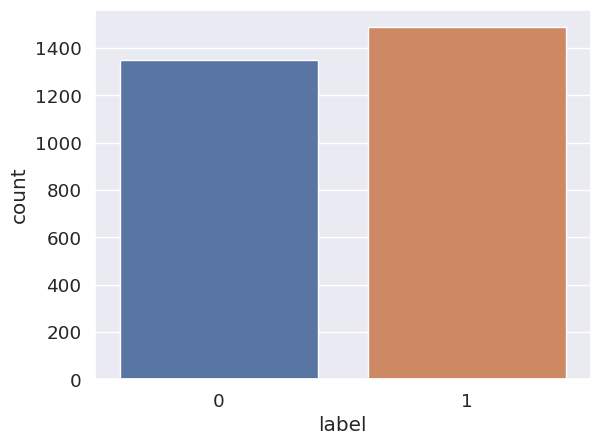

In [41]:
sns.set_style("darkgrid")
sns.countplot(data=raw_df,x=raw_df.label)

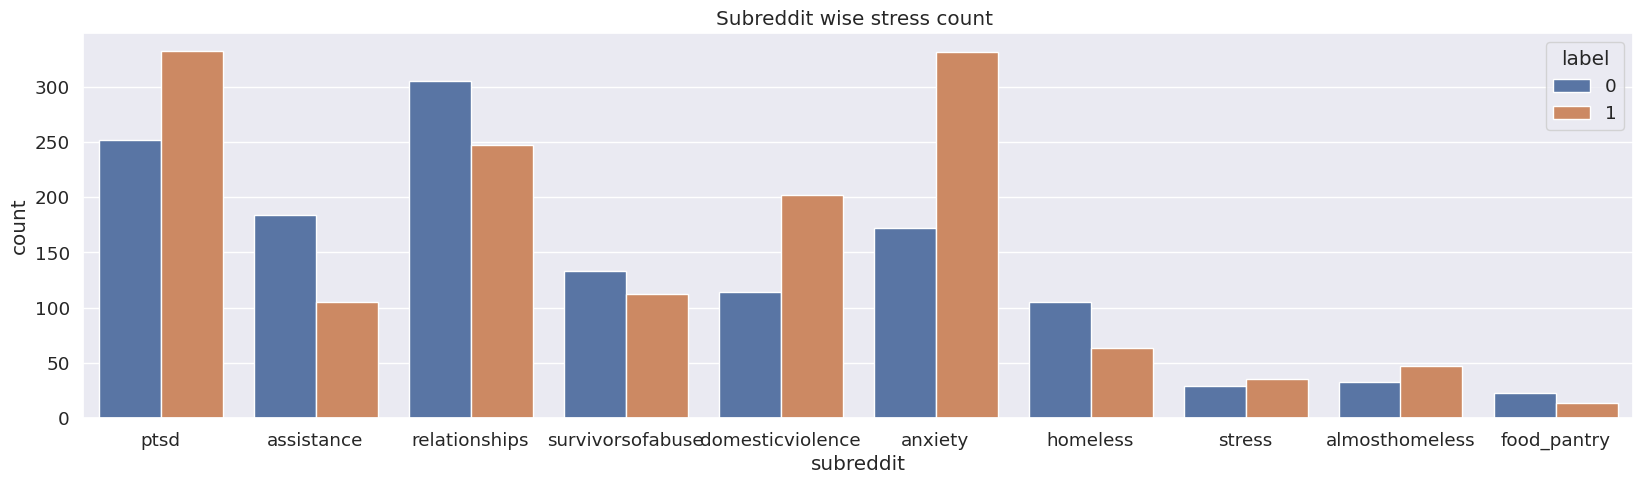

In [53]:
plt.figure(figsize=(20,5))
plt.title("Subreddit wise stress count ")
plt.xlabel("Subreddit")
sns.countplot(data=raw_df,x='subreddit',hue='label')
plt.show()

In [6]:
raw_df.isna().sum()

subreddit           0
post_id             0
sentence_range      0
text                0
label               0
confidence          0
social_timestamp    0
dtype: int64

In [7]:
raw_df.subreddit.value_counts()

ptsd                584
relationships       552
anxiety             503
domesticviolence    316
assistance          289
survivorsofabuse    245
homeless            168
almosthomeless       80
stress               64
food_pantry          37
Name: subreddit, dtype: int64

In [10]:
del raw_df['post_id']
del raw_df['sentence_range']

In [19]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
stop=set(stopwords.words('english'))
punctuation=list(string.punctuation)
stop.update(punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


## Cleaning data

In [12]:
raw_df.head()

,subreddit,text,label,confidence,social_timestamp
0,ptsd,"He said he had not felt that way before, sugge...",1,0.8,1521614353
1,assistance,"Hey there r/assistance, Not sure if this is th...",0,1.0,1527009817
2,ptsd,My mom then hit me with the newspaper and it s...,1,0.8,1535935605
3,relationships,"until i met my new boyfriend, he is amazing, h...",1,0.6,1516429555
4,survivorsofabuse,October is Domestic Violence Awareness Month a...,1,0.8,1539809005


In [27]:
nlp=spacy.load('en_core_web_sm')

In [28]:
#defining function for preprocessing
def preprocess(text,remove_digits=True):
    text = re.sub('\W+',' ', text)                                        #for replacing non-word characters
    text = re.sub('\s+',' ', text)                                        #for replacng extra spaces
    text = re.sub("(?<!\w)\d+", "", text)                                 # Remove all numbers except those attached to a word
    text = re.sub("-(?!\w)|(?<!\w)-", "", text)                           # Remove all hyphens except between two words
    text=text.lower()
    nopunc=[char for char in text if char not in string.punctuation]      #for removing punctuation in the strings
    nopunc=''.join(nopunc)
    nopunc=' '.join([word for word in nopunc.split() if word.lower() not in stopwords.words('english')])   #for removing stop words
    return nopunc
# Defining a function for lemitization
def lemmatize(words):
   
    words=nlp(words)
    lemmas = []
    for word in words:
        
        lemmas.append(word.lemma_)
    return lemmas
#converting them into string
def listtostring(s):
    str1=' '
    return (str1.join(s))

def clean_text(input):
    word=preprocess(input)
    lemmas=lemmatize(word)
    return listtostring(lemmas)

In [29]:
#Apply function on review column
raw_df['text']=raw_df['text'].apply(clean_text)

In [30]:
raw_df['text'].values

array(['say feel way suggete go rest trigger ahead youi hypocondriac like decide look feeling doom hope maybe getting suck rabbit hole ludicrous conspiracy stupid psychic test new age b something could even laugh road end read sense doom indicative various health ailment one prone top doom gloom f n worried heart happen physical hour',
       'hey r assistance sure right place post go currently student intern sandia national labs work survey help improve marketing outreach effort many school recruit around country look current undergrad grad stem student stem student know stem student would greatly appreciate help take pass along short survey thank everyone help take survey enter drawing chance win one three amazon gcs',
       'mom hit newspaper shock would know like play hit smacking strike hit violence sort person send vibe ask universe yesterday decide take friend go help another friend move new place drive friend move strike shoulder address immediately th time tell thing friend d